In [124]:
# Imports
import math
import numpy as np
import matplotlib.pyplot as plt

In [137]:
# Geometric values:
C_d = 0.75
diam = 6.5 * 0.0254               # inches to meters

# System settings
m_flow_nitrous = 1.643          # kg/s
m_flow_ethane = 0.327           # kg/s
F_thrust = 1000 * 4.44822162    # lbs -> N
m_dry = 43.68                   # kg

# environment
temp_celsius = 35               #C
humidity = 10                   # %

In [126]:
class Controller:
    def __init__(self, thrustCurve, burn_duration):
        self.thrust_curve = thrustCurve
        self.burn_duration = burn_duration

    def burning(self, t):
        return (t < self.burn_duration)

In [127]:
# Helpful functions:
def RK4(deriv, t_0, state, controller, dt = 0.01):
    k1 = dt * deriv(t_0, state, controller)
    k2 = dt * deriv(t_0 + dt / 2, state + k1 / 2, controller)
    k3 = dt * deriv(t_0 + dt / 2, state + k2 / 2, controller)
    k4 = dt * deriv(t_0 + dt, state + k3, controller)
    return state + (k1 + 2*k2 + 2*k3 + k4) / 6.0

def getCrossSectionArea():
    return math.pi * diam * diam / 4

#CHATGPT GENERATED:
def getAirDensity(altitude, temperature_celsius, relative_humidity):
    P0 = 101325  # Pressure at sea level (Pa)
    T0 = temperature_celsius + 273.15  # Temperature at sea level (Kelvin)
    L = 0.0065  # Temperature lapse rate (K/m)
    R = 8.3144598  # Universal gas constant (J/(mol·K))
    g = 9.80665  # Gravitational acceleration (m/s²)
    M = 0.0289644  # Molar mass of air (kg/mol)
    R_d = 287.05  # Specific gas constant for dry air (J/(kg·K))
    R_v = 461.495  # Specific gas constant for water vapor (J/(kg·K))

    # Calculate temperature at altitude
    temperature_at_altitude = T0 - (L * altitude)  # Kelvin

    # Calculate pressure at altitude using the barometric formula
    pressure_at_altitude = P0 * (1 - (L * altitude) / T0) ** (g * M / (R * L))

    # Calculate saturation vapor pressure (Tetens formula approximation)
    temperature_at_altitude_celsius = temperature_at_altitude - 273.15  # Kelvin to Celsius
    saturation_pressure = 6.1078 * 10 ** (
        (7.5 * temperature_at_altitude_celsius) / (temperature_at_altitude_celsius + 237.3)
    )  # hPa

    # Convert to Pascals
    saturation_pressure *= 100  # hPa to Pa

    # Calculate actual vapor pressure
    relative_humidity = relative_humidity / 100  # Percentage to fraction
    actual_vapor_pressure = saturation_pressure * relative_humidity  # Pa

    # Partial pressures
    dry_air_pressure = pressure_at_altitude - actual_vapor_pressure  # Pa

    # Mixing ratio (w)
    epsilon = R_d / R_v
    w = epsilon * (actual_vapor_pressure / dry_air_pressure)

    # Specific gas constant for moist air
    R_moist = R_d / (1 + 0.61 * w)

    # Air density using the Ideal Gas Law
    air_density = pressure_at_altitude / (R_moist * temperature_at_altitude)

    return air_density

def getDrag(altitude, velocity):
    return  0.5 * C_d * getAirDensity(altitude, temp_celsius, humidity) * velocity * getCrossSectionArea()

def getAccel(time, state, controller):
    return controller.thrust_curve(time) / state[2] - 9.81 - getDrag(state[0], state[1])

def flight_deriv(t, state, controller):
    mass_flow =  -1 * (m_flow_nitrous + m_flow_ethane) if controller.burning(t) else 0.0
    return np.array([state[1], getAccel(t,state, controller), mass_flow])

def getTrajectory(m_dot, m_prop, controller, dt = 0.01):
    time = 0.0
    times = [time]
    states = [np.array([0,0,m_dry + m_prop])] # pos, vel, mass
    peak_altitude = 0
    while (states[-1][0] >= 0):
        # Calculate next state:
        next_state = RK4(flight_deriv, time, states[-1], controller, dt)
        time += dt

        # append state:
        states.append(next_state)
        times.append(time)

        #update peak:
        peak_altitude = max(peak_altitude, next_state[0])
        #print(time, "s = ", getAccel(time,next_state, controller), " m/s^2")

    return times, states 

In [128]:
prop_ratio = m_flow_nitrous / m_flow_ethane
m_flow_tot = m_flow_nitrous + m_flow_ethane
burn_time = 2.3 #seconds
prop_mass = burn_time * m_flow_tot

def thrustDeriv(t):
    return -350 if t < burn_time else 0.0 

def thrustCurve(t):
    return F_thrust - 350 * t if t < burn_time else 0.0   #-1 * thrust_decay * F_thrust / burn_time

times, states = getTrajectory(m_flow_tot, prop_mass, Controller(thrustCurve, burn_time))

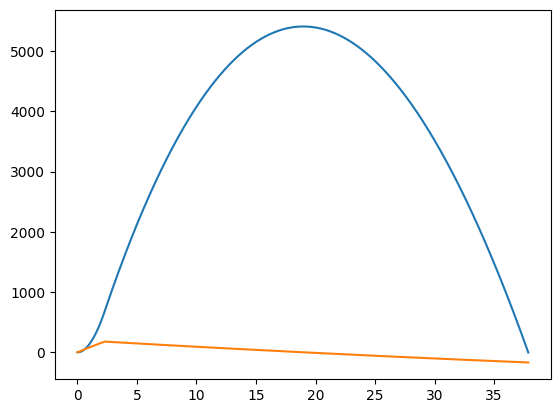

In [129]:
altitudes = [state[0] / 0.3047999902 for state in states]
velocities = [state[1] for state in states]
masses = [state[2] for state in states]
plt.plot(times, altitudes)
plt.plot(times, velocities)

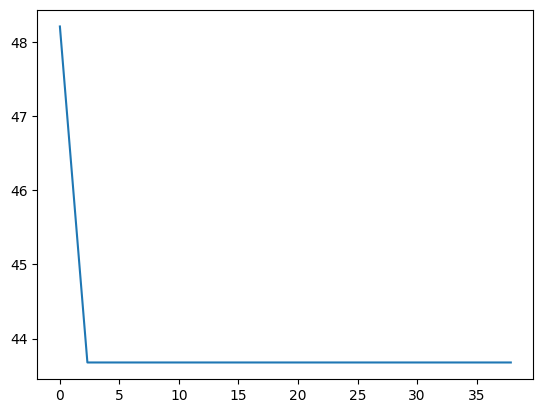

In [130]:
plt.plot(times, masses)

66.05206896551724


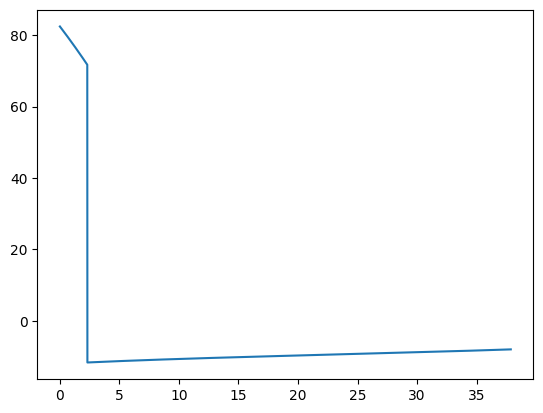

In [131]:
accels = [getAccel(t, s, Controller(thrustCurve, burn_time)) for t,s in zip(times, states)]
plt.plot(times, accels)

print((-58 * 9.81 + 4400) / 58)

In [133]:
prop_masses = []
max_alts = []

for mass in np.linspace(0,30, 300):
    print("Calculating trajectory for ", mass, " kg.", end="")
    prop_masses.append(mass)
    new_burn_time = mass / m_flow_tot

    def newThrustCurve(t):
        return F_thrust - 350 * t if t < new_burn_time else 0.0   #-1 * thrust_decay * F_thrust / burn_time

    times, states = getTrajectory(m_flow_tot, mass, Controller(newThrustCurve, new_burn_time))
    altitudes = [state[0] for state in states]
    max_alts.append(max(altitudes))
    print(" Finished Simulation. Apogee at ", max(altitudes), " meters")
    

Calculating trajectory for  0.0  kg. Finished Simulation. Apogee at  0.0  meters
Calculating trajectory for  0.10033444816053512  kg. Finished Simulation. Apogee at  1.2621626042077878  meters
Calculating trajectory for  0.20066889632107024  kg. Finished Simulation. Apogee at  4.837974526556531  meters
Calculating trajectory for  0.3010033444816054  kg. Finished Simulation. Apogee at  10.659418014400723  meters
Calculating trajectory for  0.4013377926421405  kg. Finished Simulation. Apogee at  18.65872077773484  meters
Calculating trajectory for  0.5016722408026756  kg. Finished Simulation. Apogee at  28.77014838028683  meters
Calculating trajectory for  0.6020066889632107  kg. Finished Simulation. Apogee at  42.72909119570274  meters
Calculating trajectory for  0.7023411371237458  kg. Finished Simulation. Apogee at  57.143066301663275  meters
Calculating trajectory for  0.802675585284281  kg. Finished Simulation. Apogee at  73.47498959302473  meters
Calculating trajectory for  0.90301

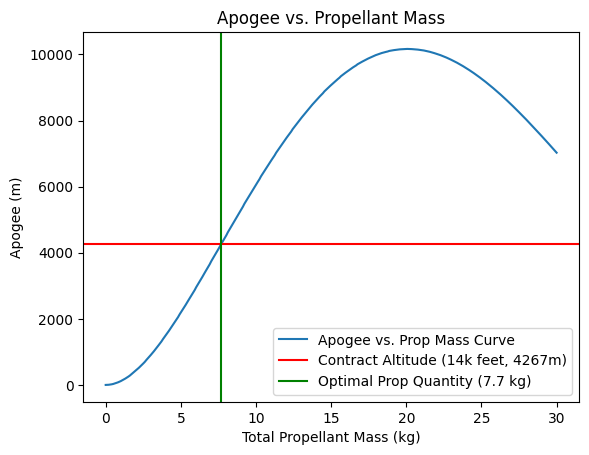

In [ ]:
plt.plot(prop_masses, max_alts, label='Apogee vs. Prop Mass Curve')
plt.ylabel("Apogee (m)")
plt.xlabel("Total Propellant Mass (kg)")
plt.title("Apogee vs. Propellant Mass")
plt.axhline(y=4267, color='r', linestyle='-', label='Contract Altitude (14k feet, 4267m)')
plt.axvline(x=7.7, color='g', linestyle='-', label='Optimal Prop Quantity (7.7 kg)')
plt.legend()

In [138]:
opt_tot_prop_mass = 7.7   #kg (rounded up )
opt_no2_prop_mass = opt_tot_prop_mass * m_flow_nitrous / m_flow_tot
opt_eth_prop_mass = opt_tot_prop_mass * m_flow_ethane / m_flow_tot
print(opt_tot_prop_mass, " kg --> ", opt_no2_prop_mass, " kg nitrous, ", opt_eth_prop_mass, " kg ethane")
rho_no2 = 1013.17 # kg/m^3
rho_eth = 786 #kg / m^3
vol_no2 = opt_no2_prop_mass / rho_no2
vol_eth = opt_eth_prop_mass / rho_eth
area = getCrossSectionArea()
no2_tank_height = vol_no2 / area
eth_tank_height = vol_eth / area
print(opt_no2_prop_mass, " --> ", vol_no2, " m^3 --> ", no2_tank_height, "m")
print(opt_eth_prop_mass, " --> ", vol_eth, " m^3 --> ", eth_tank_height, "m")

7.7  kg -->  6.4218781725888325  kg nitrous,  1.2781218274111676  kg ethane
6.4218781725888325  -->  0.0063384014258109035  m^3 -->  0.29607089240000206 m
1.2781218274111676  -->  0.0016261091951796027  m^3 -->  0.07595662821167573 m


In [139]:
print("Nitrous tank height = ", no2_tank_height  * 39.3700787, " in")
print("Ethane tank height = ", eth_tank_height  * 39.3700787, " in")

Nitrous tank height =  11.656334334567314  in
Ethane tank height =  2.9904184304803136  in
